In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ants
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal

sys.path.insert(0, '/home/users/brezovec/projects/lysis/')
from bruker import *

%matplotlib inline

In [3]:
def load_brain(file):
    brain = nib.load(file).get_data()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

def rotate_brain(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

def remove_empty_axes(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.squeeze(brain)
    brain = ants.from_numpy(brain)
    return brain

In [ ]:
brain_files = ['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/TSeries-11272018-1436-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181214/fly1/TSeries-12142018-1527-001.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181214/fly2/TSeries-12142018-1527-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly1/TSeries-12172018-1322-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/TSeries-12172018-1322-001_green.nii']

In [4]:
brain_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains'
brain_files_suf = ['brain_1.nii', 'brain_2.nii', 'brain_3.nii', 'brain_4.nii', 'brain_5.nii', 'brain_6.nii']

In [5]:
brain_files = [os.path.join(brain_folder, brain) for brain in brain_files_suf]

In [6]:
brain_files

['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_1.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_2.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_3.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_4.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_5.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_6.nii']

In [7]:
brains = []

for i, brain_file in enumerate(brain_files):
    print("loading brain", i+1)
    brain = load_brain(brain_file)
    brains.append(brain)

loading brain 1
loading brain 2
loading brain 3
loading brain 4
loading brain 5
loading brain 6


In [8]:
brains_tidy = []

for brain in brains:
    brain_tidy = remove_empty_axes(brain)
    brains_tidy.append(brain_tidy)

In [8]:
meanbrains = []

for i, brain in enumerate(brains):
    print("averaging brain", i+1)
    meanbrain = brain.mean(3)
    meanbrain = ants.from_numpy(meanbrain)
    meanbrains.append(meanbrain)

averaging brain 1


In [59]:
warps = []

for brain in brains_tidy:
    t0 = time()
    motCorr = ants.registration(brains_tidy[0],
                                brain,
                                type_of_transform='SyNCC',
                                grad_step = 0.2,
                                flow_sigma=3,
                                total_sigma=0)
    print(time()-t0)
    warped = motCorr['warpedmovout'].numpy()
    warps.append(warped)
    #warped_fixed = motCorr['warpedfixout'].numpy()

104.35129642486572
103.2754259109497
109.40834903717041
13.85060453414917
60.89576601982117
55.472426891326904


In [ ]:
warps = []

for brain in brains_tidy:
    t0 = time()
    motCorr = ants.registration(brains_tidy[0],
                                brain,
                                type_of_transform='SyNCC')
    print(time()-t0)
    warped = motCorr['warpedmovout'].numpy()
    warps.append(warped)

In [ ]:
warps = []
brain = brains_tidy[1]
t0 = time()
motCorr = ants.registration(brains_tidy[0], brain, type_of_transform='SyNCC')
print(time()-t0)
warped = motCorr['warpedmovout'].numpy()
warps.append(warped)

In [ ]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/syncc1.nii'
ants.image_write(warps[0], save_file)

In [60]:
warps_r = []

for brain in warps:
    brain_r = rotate_brain(brain)
    warps_r.append(brain_r)

In [63]:
for i, brain in enumerate(warps_r):
    save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/affine_warps/affine_warp' + str(i+1) + '.nii'
    ants.image_write(brain, save_file)

In [21]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brain_2.nii'
ants.image_write(brains[0], save_file)

In [14]:
brain_files = ['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly1/anatomy/ZSeries-12172018-1322-000.nii']

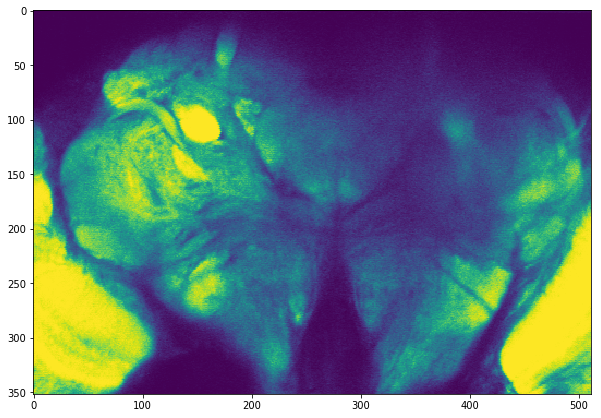

In [18]:
fig = plt.figure(figsize=[10,10])
plt.imshow(brains[0][:,:,100,0])

In [2]:
anat_f1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/anatomy/ZSeries-12172018-1322-001.nii'
anat_f2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/anatomy-000.nii'

In [30]:
nib_brain2 = nib.load(anat_f2).get_data()
nib_brain2 = np.swapaxes(nib_brain2, 0, 1)
brain2 = ants.from_numpy(nib_brain2)

In [51]:
704/2

352.0

In [53]:
271/2

135.5

In [68]:
brain1

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 55, 4006)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [69]:
brain2

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (65, 129, 41, 5805)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

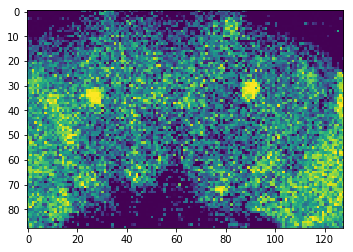

In [65]:
plt.imshow(brain1[:,:,20,0])

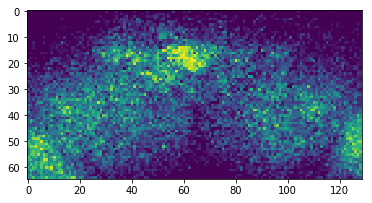

In [66]:
plt.imshow(brain2[:,:,20,0])

In [33]:
t0 = time()
motCorr_slice = ants.registration(brain1, brain2, type_of_transform='SyN')
print(time()-t0)

991.6871283054352


In [43]:
warped = motCorr_slice['warpedmovout'].numpy()
warped = np.swapaxes(warped, 0, 1)
warped = ants.from_numpy(warped)

In [21]:
np.shape(nib_brain)

(260, 516, 201, 1)

In [35]:
np.shape(thing)

(704, 1024, 271, 1)

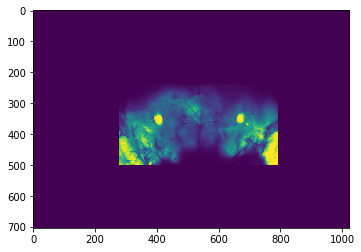

In [40]:
plt.imshow(thing[:,:,100,0])

In [46]:
ants.image_header_info(anat_f1)

{'dimensions': (1024.0, 704.0, 271.0), 'direction': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), 'nComponents': 1, 'nDimensions': 3, 'origin': (0.0,
  0.0,
  0.0), 'pixelclass': 'scalar', 'pixeltype': 'short', 'spacing': (0.0007,
  0.0007,
  0.001)}

In [57]:
mi = ants.resample_image(brain1,np.array(brain1.spacing)*2,interp_type=0) # speed up

In [59]:
np.shape(mi)

(352, 512, 136, 1)

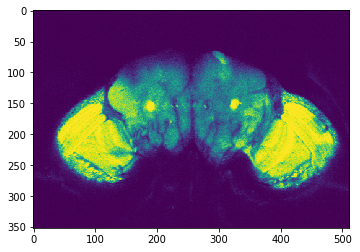

In [60]:
plt.imshow(mi[:,:,50,0])

In [11]:
meanbrain = brain.mean(3)
meanbrain = ants.from_numpy(meanbrain)

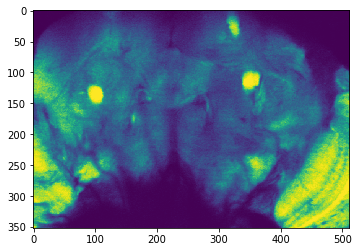

In [8]:
plt.imshow(meanbrain[:,:,100])

In [167]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/meanbrain2.nii'

In [168]:
ants.image_write(meanbrain2, save_file)

In [ ]:
### What about completely scrapping anatomy and just using mean of functional imaging?...
# let's at least try!

In [61]:
func_f1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/TSeries-12172018-1322-001_green.nii'
func_f2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/TSeries-11272018-1436-000.nii'

In [172]:
brain1 = load_brain(anat_f1)
brain2 = load_brain(anat_f2)

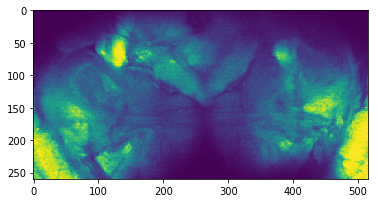

In [176]:
plt.imshow(brain2[:,:,100,0])

In [63]:
nib_brain2 = nib.load(func_f2).get_data()
nib_brain2 = np.swapaxes(nib_brain2, 0, 1)
brain2 = ants.from_numpy(nib_brain2)

In [71]:
meanbrain2 = brain2.mean(3)
meanbrain2 = ants.from_numpy(meanbrain2)

In [ ]:
### load all func brains, get mean brains, affine alignment, average all mean brains
### Then, SyNCC align mean func brains to main mean brain, then average again.
### This becomes my mean brain

In [ ]:
t0 = time()
motCorr = ants.registration(brain1,
                            brain2,
                            type_of_transform='SyNCC',
                            verbose=True,
                            grad_step = 0.2,
                            flow_sigma=3,
                            total_sigma=0,
                            reg_interations=(40,20,0))
print(time()-t0)
warped = motCorr['warpedmovout'].numpy()
warped_fixed = motCorr['warpedfixout'].numpy()

In [111]:
motCorr

{'fwdtransforms': ['/tmp/tmpr0pnb_s61Warp.nii.gz',
  '/tmp/tmpr0pnb_s60GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpr0pnb_s60GenericAffine.mat',
  '/tmp/tmpr0pnb_s61InverseWarp.nii.gz'],
 'warpedfixout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (65, 129, 41)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (88, 128, 55)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

In [170]:
def load_brain(file):
    brain = nib.load(file).get_data()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

def rotate_brain(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

In [166]:
meanbrain2 = rotate_brain(meanbrain2)

In [154]:
type(warped) == 'numpy.ndarray'

False

In [153]:
str(type(warped))

"<class 'numpy.ndarray'>"

In [105]:
warped = motCorr_slice['warpedmovout'].numpy()
#warped = np.swapaxes(warped, 0, 1)
#warped = ants.from_numpy(warped)

In [95]:
meanbrain1 = meanbrain1.numpy()
meanbrain1 = np.swapaxes(meanbrain1, 0, 1)
meanbrain1 = ants.from_numpy(meanbrain1)

In [ ]:
meanbrain2 = meanbrain2.numpy()
meanbrain2 = np.swapaxes(meanbrain2, 0, 1)
meanbrain2 = ants.from_numpy(meanbrain1)

In [82]:
warped

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (128, 88, 55)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

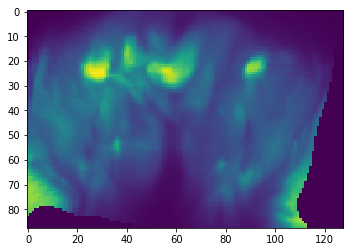

In [89]:
plt.imshow(warped[:,:,29])

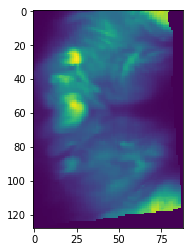

In [160]:
plt.imshow(warped[:,:,29])

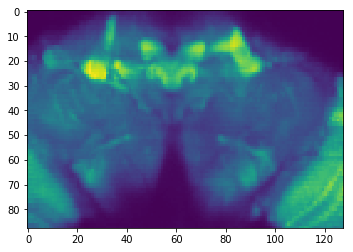

In [137]:
plt.imshow(meanbrain1[:,:,29])

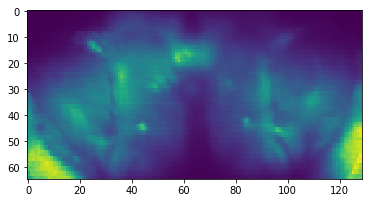

In [131]:
plt.imshow(meanbrain2[:,:,29])

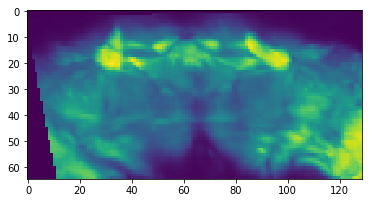

In [140]:
plt.imshow(warped_fixed[:,:,20])